<a href="https://colab.research.google.com/github/YuvarajGML/YuvarajGML/blob/main/Binary_Waste_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d alistairking/recyclable-and-household-waste-classification

Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification
License(s): MIT
 99% 913M/920M [00:09<00:00, 91.2MB/s]
100% 920M/920M [00:09<00:00, 107MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/recyclable-and-household-waste-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


Epoch [1/10], Train Loss: 3.6559, Val Loss: 2.4163
Epoch [2/10], Train Loss: 2.0344, Val Loss: 1.4841
Epoch [3/10], Train Loss: 0.9746, Val Loss: 1.1509
Epoch [4/10], Train Loss: 0.4610, Val Loss: 1.1417
Epoch [5/10], Train Loss: 0.2870, Val Loss: 1.1500
Epoch [6/10], Train Loss: 0.2121, Val Loss: 1.2083
Epoch [7/10], Train Loss: 0.1747, Val Loss: 1.2356
Epoch [8/10], Train Loss: 0.1439, Val Loss: 1.1839
Epoch [9/10], Train Loss: 0.1372, Val Loss: 1.2145
Epoch [10/10], Train Loss: 0.1414, Val Loss: 1.2409
Training completed!


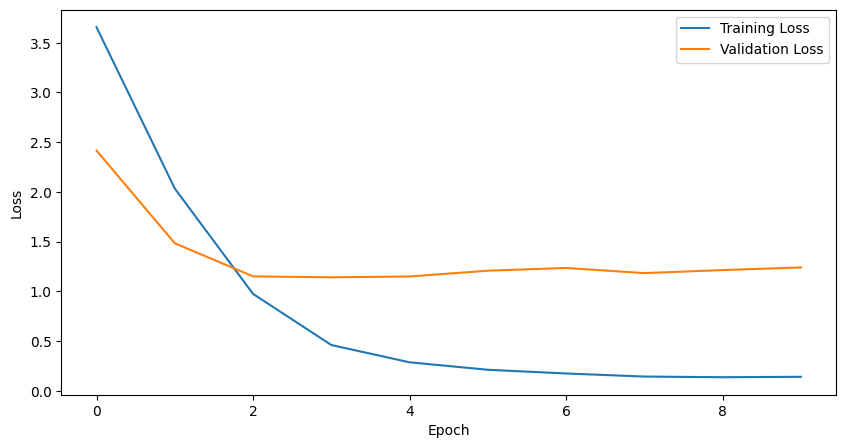

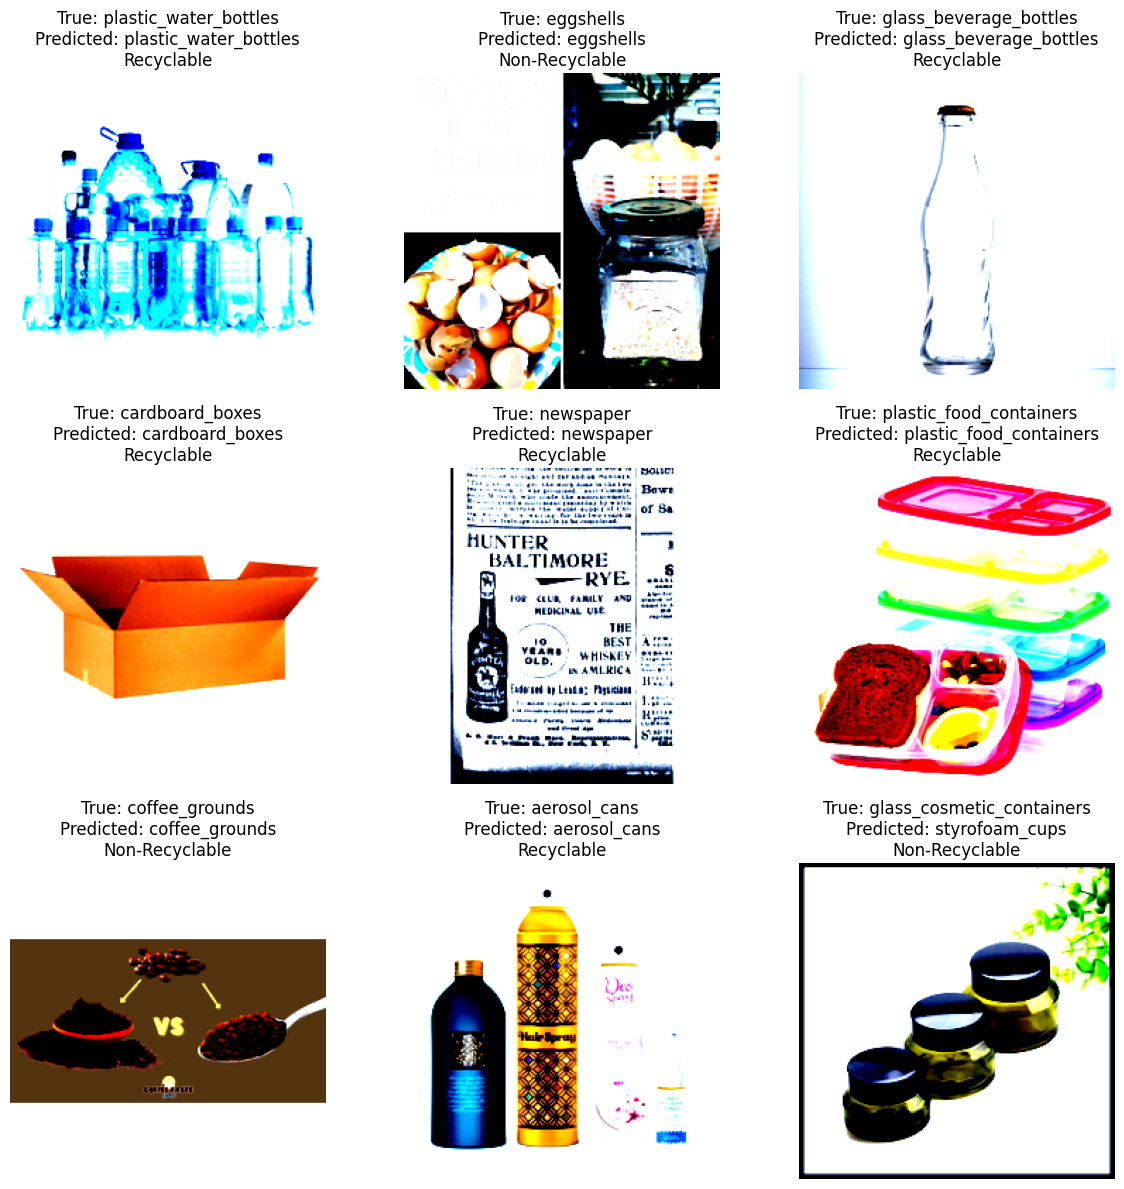

Image 1: Predicted as plastic_water_bottles - Recyclable
Image 2: Predicted as eggshells - Non-Recyclable
Image 3: Predicted as glass_beverage_bottles - Recyclable
Image 4: Predicted as cardboard_boxes - Recyclable
Image 5: Predicted as newspaper - Recyclable
Image 6: Predicted as plastic_food_containers - Recyclable
Image 7: Predicted as coffee_grounds - Non-Recyclable
Image 8: Predicted as aerosol_cans - Recyclable
Image 9: Predicted as styrofoam_cups - Non-Recyclable


In [ ]:




#
# We start by importing the necessary libraries for our project:
#
# - `os` for file and directory operations
# - `torch` and `torch.nn` for building and training the neural network
# - `torch.optim` for optimization algorithms
# - `torch.utils.data` for creating data loaders and custom datasets
# - `torchvision.transforms` for image transformations
# - `PIL` for image loading and manipulation
# - `matplotlib.pyplot` for visualizing images and plots
# - `random` for random number generation

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random


# ## Custom Dataset Class
#
# We define a custom `WasteDataset` class that inherits from PyTorch's `Dataset` class. This class is responsible for loading and preprocessing the images from the dataset.
#
# ### Initialization
#
# The `__init__` method takes the following parameters:
# - `root_dir`: The root directory containing the dataset images.
# - `split`: The dataset split (train, validation, or test).
# - `transform`: Optional image transformations to be applied.
#
# Inside the `__init__` method, we:
# 1. Store the `root_dir`, `transform`, and `split` parameters.
# 2. Get the list of class names by listing the directories in `root_dir`.
# 3. Initialize empty lists for `image_paths` and `labels`.
# 4. Iterate over each class directory and its subfolders ('default' and 'real_world').
# 5. Shuffle the image names in each subfolder.
# 6. Based on the `split` parameter, select a portion of the images (60% for train, 20% for validation, 20% for test).
# 7. Append the image paths and corresponding labels to the respective lists.
#
# ### Length and Item Retrieval
#
# The `__len__` method returns the total number of images in the dataset.
#
# The `__getitem__` method takes an `index` and returns the image and its corresponding label at that index. It:
# 1. Retrieves the image path and label using the provided index.
# 2. Opens the image using `Image.open()` and converts it to RGB format.
# 3. Applies the specified image transformations, if any.
# 4. Returns the transformed image and its label.
#
# This custom dataset class allows us to easily load and preprocess the waste images for training, validation, and testing.


# Define the dataset class (modified to include a split parameter)
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label



#
# ### Initialization
#
# The `__init__` method takes the following parameter:
# - `num_classes`: The number of output classes in the classification task.
#
# Inside the `__init__` method, we define the layers of the CNN:
# 1. `conv1`: A 2D convolutional layer with 3 input channels, 32 output channels, a kernel size of 3, stride of 1, and padding of 1.
# 2. `relu`: A ReLU activation function.
# 3. `maxpool`: A 2D max pooling layer with a kernel size of 2 and stride of 2.
# 4. `conv2`: Another 2D convolutional layer with 32 input channels, 64 output channels, a kernel size of 3, stride of 1, and padding of 1.
# 5. `fc1`: A fully connected layer that takes the flattened output of `conv2` and maps it to 512 features.
# 6. `fc2`: The final fully connected layer that takes the 512 features and maps them to the number of output classes.
#
# ### Forward Pass
#
# The `forward` method defines the forward pass of the CNN model. It takes an input tensor `x` and applies the following operations:
# 1. Pass `x` through `conv1`, followed by `relu` activation and `maxpool`.
# 2. Pass the output through `conv2`, followed by `relu` activation and `maxpool`.
# 3. Flatten the output of `conv2` using `x.view(x.size(0), -1)`.
# 4. Pass the flattened tensor through `fc1`, followed by `relu` activation.
# 5. Pass the output of `fc1` through `fc2` to obtain the final output.
#
# The output of the `forward` method represents the predicted class scores for each input sample.
#
# This CNN architecture is designed to learn hierarchical features from the input images and make predictions based on those features. The convolutional layers capture local patterns, the pooling layers reduce spatial dimensions, and the fully connected layers perform the final classification.

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x) # Detects local patterns like edges or textures in the image.
        x = self.relu(x)  #Detects local patterns like edges or textures in the image.
        x = self.maxpool(x) # Detects local patterns like edges or textures in the image.
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)  #Learn the relationships between features and classes.
        x = self.relu(x) # Introduces further non-linearity
        x = self.fc2(x) # Learn the relationships between features and classes.
        return x


# ## Dataset Path and Hyperparameters
#
# We set the following dataset path and hyperparameters:
# - `dataset_path`: The path to the directory containing the dataset images.
# - `batch_size`: The number of samples per batch during training and evaluation.
# - `num_epochs`: The number of epochs to train the model.
# - `learning_rate`: The learning rate for the optimizer.
#
# These hyperparameters can be adjusted based on the specific requirements and available computational resources.


dataset_path = '/content/images/images'
batch_size = 32
num_epochs = 10
learning_rate = 0.001


# ## Data Preprocessing and Loaders
#
# We define a composition of image transformations using `transforms.Compose`:
# 1. `transforms.Resize((224, 224))`: Resizes the images to a fixed size of (224, 224) pixels.
# 2. `transforms.ToTensor()`: Converts the images to PyTorch tensors.
# 3. `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normalizes the image tensors using the specified mean and standard deviation values.
#
# These transformations ensure that the images are preprocessed consistently before being fed into the model.
#
# We create instances of the `WasteDataset` class for the train, validation, and test splits, passing the `dataset_path`, `split`, and `transform` parameters. This allows us to load the dataset images with the specified transformations for each split.
#
# Finally, we create data loaders for each dataset using `DataLoader`:
# - `train_dataloader`: Loads the training data in batches of size `batch_size` and shuffles the samples.
# - `val_dataloader`: Loads the validation data in batches of size `batch_size` without shuffling.
# - `test_dataloader`: Loads the test data in batches of size `batch_size` without shuffling.
#
# The data loaders provide an efficient way to iterate over the dataset during training and evaluation, handling batching and shuffling as specified.


# Create the datasets and data loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = WasteDataset(dataset_path, split='train', transform=transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# ### Model Initialization
#
# We create an instance of the `CNN` model, passing the `num_classes` parameter. The `num_classes` is determined by the number of unique classes in the dataset, which is obtained using `len(dataset.classes)`. This ensures that the model's output layer has the correct number of units corresponding to the number of classes.
#
# The model is then moved to the GPU using `.to('cuda')` to take advantage of GPU acceleration for faster training and inference.
#
# ### Loss Function
#
# We define the loss function using `nn.CrossEntropyLoss()`. Cross-entropy loss is commonly used for multi-class classification tasks. It measures the dissimilarity between the predicted class probabilities and the true class labels, providing a measure of how well the model is performing.
#
# ### Optimizer
#
# We create an optimizer using `optim.Adam()`, passing the model's parameters (`model.parameters()`) and the learning rate (`lr=learning_rate`). Adam (Adaptive Moment Estimation) is a popular optimization algorithm that adapts the learning rate for each parameter based on the first and second moments of the gradients. It combines the benefits of AdaGrad and RMSprop optimizers.
#
# The optimizer is responsible for updating the model's parameters during the training process based on the computed gradients and the specified learning rate.
#
# With the model, loss function, and optimizer defined, we are ready to proceed with training the CNN model on the waste classification dataset.


# Create the model, loss function, and optimizer
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


#
# We define lists `train_losses` and `val_losses` to store the training and validation losses for each epoch, respectively. These lists will be used to monitor the model's performance during training.
#
# The training loop iterates over the specified number of epochs (`num_epochs`). In each epoch, we perform the following steps:
#
# ### Training Phase
#
# 1. Set the model to training mode using `model.train()`. This enables dropout and batch normalization layers to update their parameters during training.
#
# 2. Initialize the `train_loss` variable to keep track of the cumulative training loss for the current epoch.
#
# 3. Iterate over the training data using `train_dataloader`:
#   - Move the images and labels to the GPU using `.to('cuda')`.
#   - Forward pass: Pass the images through the model to obtain the predicted outputs.
#   - Compute the loss using the defined criterion (`criterion(outputs, labels)`).
#   - Backward pass: Zero the gradients using `optimizer.zero_grad()`, compute the gradients using `loss.backward()`, and update the model parameters using `optimizer.step()`.
#   - Accumulate the training loss for the current batch.
#
# 4. Compute the average training loss for the epoch by dividing the cumulative loss by the total number of training samples.
#
# 5. Append the average training loss to the `train_losses` list.
#
# ### Validation Phase
#
# 1. Set the model to evaluation mode using `model.eval()`. This disables dropout and batch normalization layers during inference.
#
# 2. Initialize the `val_loss` variable to keep track of the cumulative validation loss for the current epoch.
#
# 3. Disable gradient computation using `torch.no_grad()` to speed up the validation process.
#
# 4. Iterate over the validation data using `val_dataloader`:
#   - Move the images and labels to the GPU using `.to('cuda')`.
#   - Forward pass: Pass the images through the model to obtain the predicted outputs.
#   - Compute the loss using the defined criterion (`criterion(outputs, labels)`).
#   - Accumulate the validation loss for the current batch.
#
# 5. Compute the average validation loss for the epoch by dividing the cumulative loss by the total number of validation samples.
#
# 6. Append the average validation loss to the `val_losses` list.
#
# After each epoch, we print the current epoch number, training loss, and validation loss to monitor the progress of the training process.
#
# Once all epochs are completed, we print a message indicating that the training is finished.


# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# ## Results Visualization
#
# In this section, we visualize the results from training and inference.

import torch
import matplotlib.pyplot as plt

# Define the recyclable and non-recyclable categories (Modify this list as per your classes)
recyclable_classes = ['aerosol_cans' , 'aluminum_food_cans' ,'aluminum_soda_cans' , 'cardboard_boxes' , 'cardboard_packaging' , 'glass_beverage_bottles' ,'glass_cosmetic_containers' , 'glass_food_jars' ,'magazines' , 'newspaper' , 'office_paper' , 'plastic_food_containers' , 'plastic_soda_bottles' , 'plastic_water_bottles' , 'steel_food_cans','shoes' , 'eggshells' , 'food_waste' , 'paper_cups','clothing' , 'coffee_grounds' ]
non_recyclable_classes = [ 'disposable_plastic_cups' , 'plastic_cup_lids' , 'plastic_shopping_bags' , 'plastic_straws' , 'plastic_detergent_bottles','plastic_trash_bags'   , 'styrofoam_cups' , 'styrofoam_food_containers' , 'tea_bags']

# Define a confidence threshold (e.g., 50% confidence)
confidence_threshold = 0.5

model.eval()  # Set the model to evaluation mode

# Initialize lists to store the selected images and predictions
selected_images = []
selected_labels = []
selected_predicted = []
selected_predictions = []  # To store 'Recyclable' or 'Non-Recyclable' labels

# Loop through test data and make predictions
with torch.no_grad():
    indices = list(range(len(test_dataset)))  # All indices in the test dataset
    random.shuffle(indices)  # Shuffle for randomness

    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU

        output = model(image)  # Get model output
        softmax_output = torch.softmax(output, dim=1)  # Apply softmax to get class probabilities
        confidence, predicted = torch.max(softmax_output, 1)  # Get predicted class and confidence

        # Check if the confidence is above the threshold
        if confidence.item() >= confidence_threshold:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())

            # Check if the predicted class is recyclable or non-recyclable
            predicted_class = train_dataset.classes[predicted.item()]
            if predicted_class in recyclable_classes:
                selected_predictions.append("Recyclable")
            else:
                selected_predictions.append("Non-Recyclable")

        # Stop after collecting 9 images (for visualization)
        if len(selected_labels) == 9:
            break

# Plot the selected images and predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(9):
    axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))  # Display image
    true_label = train_dataset.classes[selected_labels[i]]
    predicted_label = train_dataset.classes[selected_predicted[i]]
    prediction_label = selected_predictions[i]
    axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}\n{prediction_label}")
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

# Print the predictions as Recyclable or Non-Recyclable
for i in range(9):
    print(f"Image {i+1}: Predicted as {train_dataset.classes[selected_predicted[i]]} - {selected_predictions[i]}")





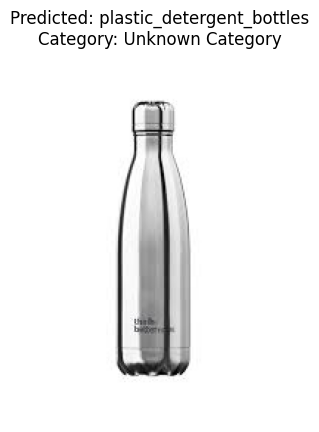

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Function to test the model with a custom image
def test_with_custom_image(image_path, model, transform, recyclable_classes, non_recyclable_classes):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Preprocess the image
    processed_image = transform(image).unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Pass the image through the model
        output = model(processed_image)
        _, predicted = torch.max(output, 1)  # Get the predicted class index

    # Map the predicted index to the class name
    predicted_class = train_dataset.classes[predicted.item()]

    # Determine if the predicted class is recyclable or non-recyclable
    if predicted_class in recyclable_classes:
        category = "Recyclable"
    elif predicted_class in non_recyclable_classes:
        category = "Non-Recyclable"
    else:
        category = "Unknown Category"

    # Display the image and prediction
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nCategory: {category}")
    plt.show()

# Test the model with a custom image
image_path = '/content/download.jpg'  # Replace with your custom image path
test_with_custom_image(image_path, model, transform, recyclable_classes, non_recyclable_classes)



Epoch [1/10], Train Loss: 3.9950, Val Loss: 3.4013, Train Accuracy: 0.0318, Val Accuracy: 0.0337
Epoch [2/10], Train Loss: 3.3555, Val Loss: 3.2501, Train Accuracy: 0.0646, Val Accuracy: 0.0923
Epoch [3/10], Train Loss: 2.5005, Val Loss: 1.5007, Train Accuracy: 0.3364, Val Accuracy: 0.6127
Epoch [4/10], Train Loss: 0.8695, Val Loss: 1.0355, Train Accuracy: 0.7707, Val Accuracy: 0.7680
Epoch [5/10], Train Loss: 0.2731, Val Loss: 0.9560, Train Accuracy: 0.9354, Val Accuracy: 0.7907
Epoch [6/10], Train Loss: 0.1551, Val Loss: 0.9519, Train Accuracy: 0.9604, Val Accuracy: 0.7963
Epoch [7/10], Train Loss: 0.1182, Val Loss: 0.9549, Train Accuracy: 0.9654, Val Accuracy: 0.8030
Epoch [8/10], Train Loss: 0.1004, Val Loss: 1.0137, Train Accuracy: 0.9689, Val Accuracy: 0.8047
Epoch [9/10], Train Loss: 0.0880, Val Loss: 0.9089, Train Accuracy: 0.9707, Val Accuracy: 0.8017
Epoch [10/10], Train Loss: 0.0816, Val Loss: 0.9707, Train Accuracy: 0.9702, Val Accuracy: 0.8030


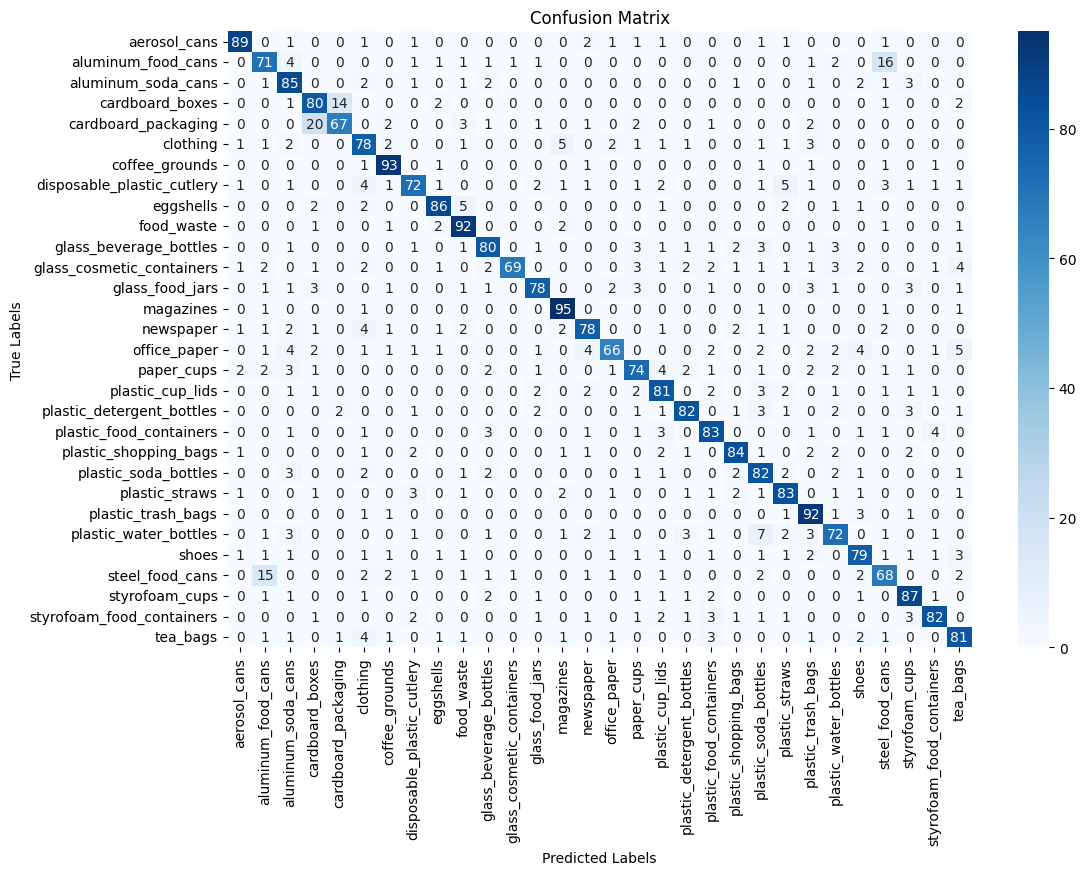

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import sklearn.metrics as metrics
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

# Define the dataset class (modified to include a split parameter)
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Dataset Path and Hyperparameters
dataset_path = '/content/images/images'
batch_size = 32
num_epochs = 10
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = WasteDataset(dataset_path, split='train', transform=transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Initialization
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store the training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lr_list = []

# Training loop with accuracy tracking
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    correct_train = 0
    total_train = 0
    train_loss = 0.0

    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Update training loss and accuracy
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Update validation loss and accuracy
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print out results for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


# Confusion Matrix
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = metrics.confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()






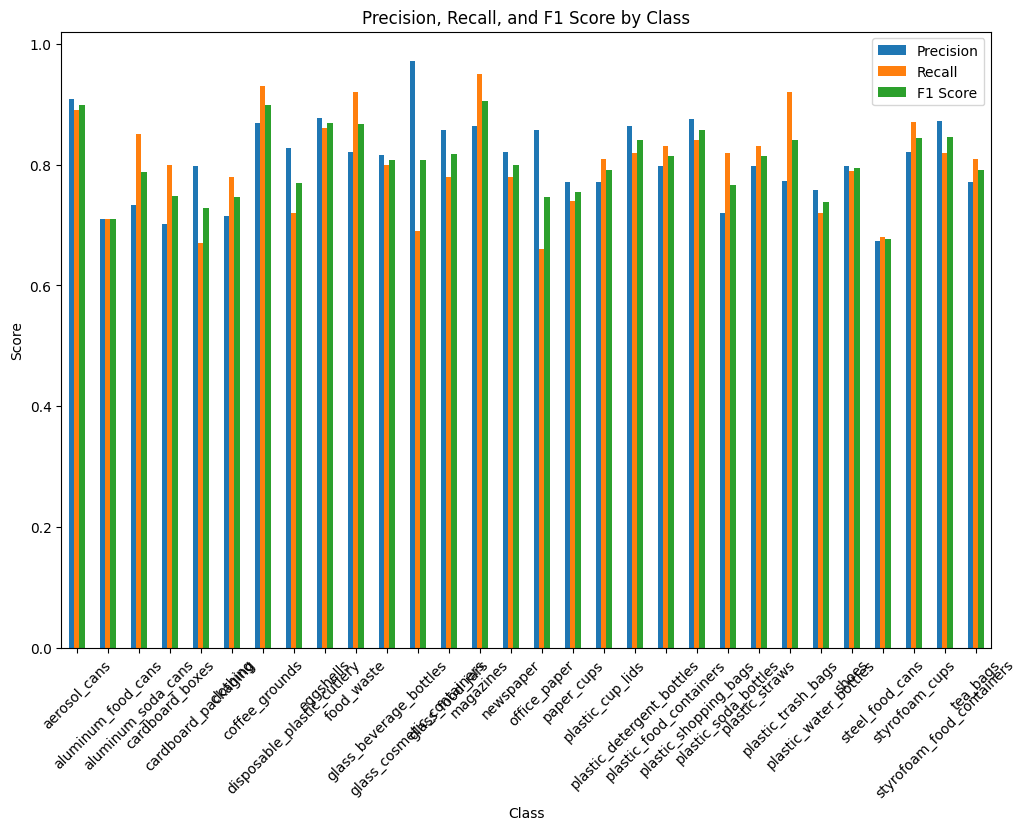

In [ ]:
# Precision, Recall, F1 Score
precision, recall, f1, _ = metrics.precision_recall_fscore_support(all_labels, all_predictions)

metrics_df = pd.DataFrame({
    'Class': train_dataset.classes,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

metrics_df.set_index('Class').plot(kind='bar', figsize=(12, 8))
plt.title('Precision, Recall, and F1 Score by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


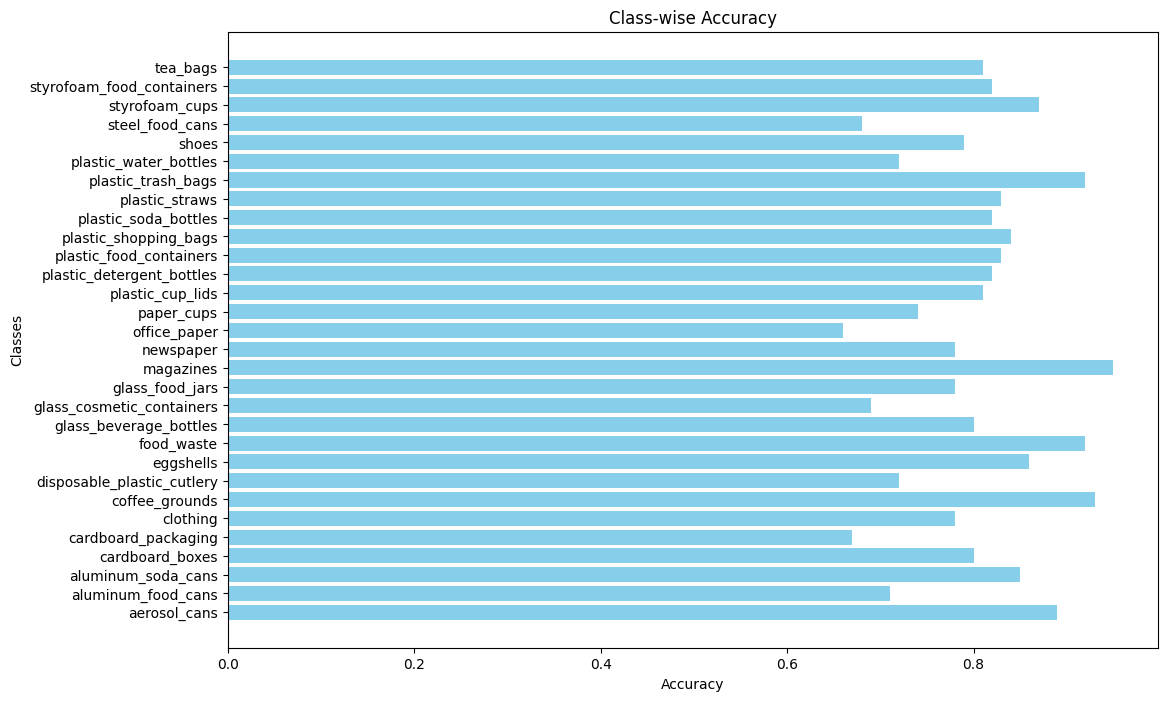

In [ ]:
# Class-wise accuracy
class_correct = [0] * len(train_dataset.classes)
class_total = [0] * len(train_dataset.classes)

with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i]
            class_total[label] += 1
            if predicted[i] == label:
                class_correct[label] += 1

class_accuracies = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(len(train_dataset.classes))]

plt.figure(figsize=(12, 8))
plt.barh(train_dataset.classes, class_accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Classes')
plt.title('Class-wise Accuracy')
plt.show()


